> 1. DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.
> 2. SET THE "General Access" OF THE COPIED NOTEBOOK TO "Anyone with the link" BY CLICKING ON "Share" TO ENABLE SHARING WITH YOUR PEERS FOR REVIEW.


### This project is from the *Causal Inference for Data Science course on CoRise.* Learn more about the course [here](https://corise.com/course/causal-inference-for-data-science).



---





# Week 1 Project: Applying Linear Regression
***

Welcome to the first project for Causal Inference for Data Science!


## Scenario

Throughout this course, you will assume the role of a Data Scientist for Tongass, a retailer that sells goods online and in physical stores.

One day, a Tongass executive passes by your desk (or Zoom square) and asks, "Hey, you know things about data, right?"

"I like to think so," you reply as you lean back into your seat.

"Great... Because I've been thinking... How much of a benefit do we get from our physical stores anyway?"

"Benefit?" you ask.

"Like, if we can convince a customer to shop in person, does that boost their ultimate value to Tongass?"

"Hmmm," you say, "an interesting and important question. I'll look into it and report back!"

**This is the question we'll be interested in tackling — not only this week, but in weeks to come.**


## Project notes

### Data

We will work with a consistent data set througout this course (we introduce the data set more fully below). Not all parts of the data set will be applicable in any given week. The goal is demonstrating how a single set of granular data can be transformed to apply different causal inference techniques. We also hope to convey that manipulating data is in many ways the most important aspect of statistical modeling.

### Structure

We attempt to strike a balance between providing concrete steps to follow and making room for exploration. That said, we encourage you to explore: The best way to become a causal inference expert is to attack a single problem from multiple angles to see how different modeling choices affect an analysis. If this freedom is overwhelming, **don't panic**! You can simply fill out the code blocks marked "TODO" and ignore the optional ones. When we ask you to build models, we will provide the treatment effect you should expect so you can check your work.

In [ ]:
# loading necessary packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

<br/>

## I. Load the data
***

We will work with a consistent data set throughout this course. The data set is in the file called `tongass_transactions.csv`.

Note: The data set is at the **transaction level**, not the customer level. Any given customer can (and likely does) have multiple transactions. Some measures and fields are at the customer level, while others are at the transaction level. It will be up to you to manipulate this data set so that it can be used for analysis. Note that the question we're interested in is fundamentally about *customers, not transactions,* which means we'll likely need to aggregate the data to the customer level to make it useful.

Below, we define the fields that are relevant for this week:
- `customer_id`: the unique identifier for a given customer
- `age`: the age of the customer
- `income`: the income of the customer
- `state`: the customer's state of residence
- `distance`: the distance (in miles) from a customer's home to the nearest Tongass store
- `tx_order`: whether the transaction is the customer's first, second, third... etc.
- `amount`: the dollar value of the transaction
- `tx_date`: the date of the transaction
- `is_credit`: whether the transaction involved a credit card or a different payment method (1 if credit card, 0 if other)
- `in_store`: whether the transaction happened in a physical store (1 if yes, 0 if no and happened on tongass.com)

**NOTE**: If we don't mention a field above, then it won't be relevant for this week :)

In [ ]:
# TODO: read in data (already filled out for you :)
url = 'https://raw.githubusercontent.com/dsaber/co-rise-causal-inference/main/tongass_transactions.csv'
df = pd.read_csv(url)
df.head(5)

,customer_id,age,income,state,received_re,received_in_store_re,distance,index,tx_order,amount,in_store,tx_date,is_credit,is_bonus
0,0,65,122753,ND,0,0,6.765402,0,0.0,61.964375,0.0,2020-12-31,0.0,0.0
1,0,65,122753,ND,0,0,6.765402,1,1.0,41.057234,0.0,2021-03-31,0.0,0.0
2,0,65,122753,ND,0,0,6.765402,2,2.0,71.752128,1.0,2021-06-30,1.0,0.0
3,0,65,122753,ND,0,0,6.765402,3,3.0,93.129942,1.0,2022-10-31,1.0,0.0
4,1,79,32977,DC,0,0,3.146723,0,0.0,61.334116,0.0,2020-01-31,0.0,0.0


<br/>

## II. Familiarize yourself with the data set and determine if the causal question is worth investigating (spoiler: it will be)
***

Before we build any models, we should deeply understand the data set we're working with.

In this section, you are free to do anything you would typically do when working with a new set of data; however, at a minimum, we recommend:
- Visualizing at least three key distributions (e.g., the number of transactions per customer, the dollar value of transactions/customers, etc.).
- Investigating whether the key causal question is worth investigating (e.g., by looking at whether customers who shop in store spend more money overall). One simple way to do this could be by looking at how customer value varies with the proportion of their transactions that occur in a physical store.
- Looking at which other variables might relate to customer value (e.g., age, income).

To get you started, we visualize a distribution below.

In [ ]:
dfc = df.groupby('customer_id').agg({
    'tx_order': 'count',
    'amount': 'sum'
    }).rename(columns={'tx_order': 'num_transactions', 'amount': 'customer_value'}).reset_index()

[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Number of customers with X transactions')]

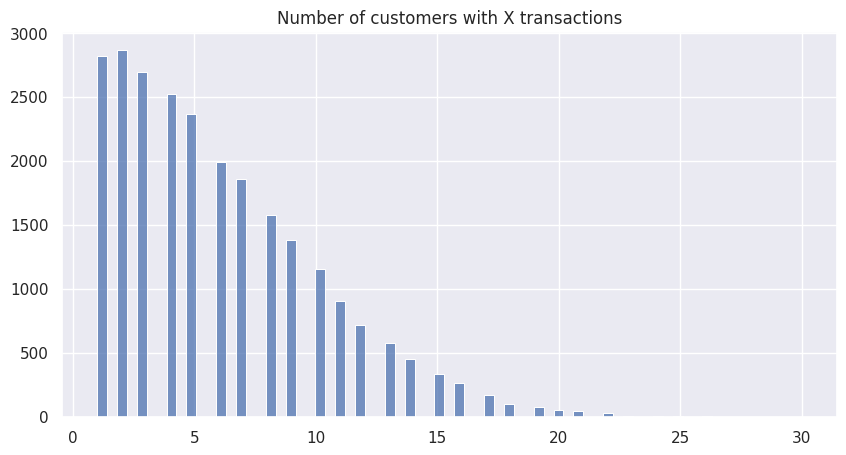

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(dfc['num_transactions'], ax=ax)
ax.set(
    xlabel='',
    ylabel='',
    title='Number of customers with X transactions'
)

In [ ]:
# TODO: visualize a key distribution (e.g., dollar value per customer, dollar value per customer cohort, etc.)

In [ ]:
# TODO: determine if customer value seems correlated with in-store shopping

In [ ]:
# TODO: determine if other variables (e.g., number of transactions, age, distance, etc.)
# seems correlated with in-store shopping

## III. Decide how you will approach the causal question of interest and manipulate the data accordingly
***

As you have likely noticed, our Tongass executive asked us a fairly high-level strategic question. They are broadly interested in the relationship between in-store shopping and customer value, but beyond that, they didn't provide additional structure.

In reality, you would have asked them additional follow-ups about how exactly this analysis would inform decision-making, but regardless, "translating" between vague high-level questions and the concrete act of preparing a statistical model is one of the main ways data scientists add value!

So let's do it.

### Approach 1

To start, let's think about the ways you could approach this problem. One simple way might be to say, "Well, we have a bunch of transactions data. We could simply aggregate it at the customer level and see whether customers who have a higher in-store shopping rate are more valuable."

In that case, the data would look something like this...

In [ ]:
df_model1 = df.groupby('customer_id').agg({
    'in_store': 'mean', # the rate at which customer shops in store (treatment variable)
    'amount': 'sum', # the total amount a customer has spent (outcome variable)
    'tx_order': 'max', # a key control — the number of transactions this customer makes
    # TODO: if you choose this approach, figure out how to construct the rest of the data set,
    # including key variables like distance, age, etc.
}).reset_index()

print(df_model1.shape)
df_model1.head()

(25000, 4)


,customer_id,in_store,amount,tx_order
0,0,0.500000,267.903678,3.0
1,1,0.823529,1604.529401,16.0
2,2,0.750000,302.195168,3.0
3,3,0.428571,511.422005,6.0
4,4,0.500000,705.293409,7.0


Approaching the data this way would translate to the following causal problem: **"If we can boost the rate at which the typical customer shops in person, how does their long-run value change?"**

A couple of notes:
1. We're not preparing the data set for you completely — where would the fun be in that? ;)
2. Even in this formulation of the problem, there are still additional choices for us to make. For example, rather than looking at the "in-store shopping rate," we could look at whether a customer ever had *any* in-store transaction. Both decisions are reasonable, and both would communicate something slightly different. It's up to us to decide which concept is more meaningful given the data we have and the strategic decisions we wish to inform. (Don't worry about changing the above code to account for this note — this is mostly to point out there are many subtle ways we can construct data.)

### Approach 2

Alternatively, it could be more elegant (albeit complex) to reframe this problem as happening at a specific point in time to a specific population.

In particular, rather than looking at the data set as a whole, we could pick an arbitrary month and say, **"Hey, let's consider all the customers who only ever shopped online up till that point. The 'treatment' will then be shopping in person for the first time during that month of interest."**

The bones of this data manipulation would look something like this...

In [ ]:
df_model2 = df.copy()
date_range = np.sort(df_model2['tx_date'].unique())

# arbitrarily take middle of date range as month of "intervention"
intervention_month = date_range[len(date_range)//2]

# get customers who had a transaction in month of "intervention"
customers = df_model2[df_model2['tx_date'] == intervention_month][['customer_id', 'in_store']]

df_model2['pre_intervention'] = df_model2['tx_date'] < intervention_month

df_model2 = df_model2.groupby(['customer_id', 'pre_intervention']).agg({
    'in_store': 'max',
    'amount': 'sum',
    'tx_order': 'max' # count number of transactions for this customer
    # TODO: if you choose this approach, figure out how to construct the rest of the data set,
    # including key variables like distance, age, etc.
}).reset_index()

In [ ]:
# filter to customers who only shopped online before "intervention"
df_model2_pre = df_model2[(df_model2['pre_intervention'] == True) & (df_model2['in_store'] == 0)].drop(columns=['amount', 'in_store'])

# join on relevant customer population and get "treatment" — whether they
# shopped in store or online during relevant month
df_model2_pre = pd.merge(df_model2_pre, customers, on='customer_id', how='inner')

# get outcome for above customers
df_model2_post = df_model2[df_model2['pre_intervention'] == False][['customer_id', 'amount']]

# combine these data sets
df_model2_final = pd.merge(df_model2_pre, df_model2_post, how='left', on='customer_id').fillna(0)

print(df_model2_final.shape)
df_model2_final.head()

(698, 5)


,customer_id,pre_intervention,tx_order,in_store,amount
0,64,True,1.0,1.0,233.056367
1,67,True,0.0,1.0,263.104737
2,84,True,1.0,1.0,271.067656
3,95,True,3.0,1.0,218.513530
4,139,True,0.0,1.0,148.357707


The code is much more complicated, but it elegantly maps to the following causal question: **"If we convince a purely online shopper to buy something in a store, how much extra value does that generate in the long-run?"**

That's an interesting (and actionable!) question, so it could be worth the data munging pain. Whether you agree is up to you ;)

Also note that this approach _does_ involve throwing out a lot of data. In a future version of this analysis, it might be worth thinking about whether there are ways to structure the problem so that we throw out less, or, if you go down this path, to consider repeating this analysis for different months to see if the result is robust.

**NOTE**: If this framing of the problem seems at all confusing, don't worry! Just go with Approach 1.

### Note on Step III

There's a reason we're spending a lot of time on this section. It might seem silly, but this is often the most complex part of any modeling problem. Once you have your data in place, fitting models and deciding which works best is often a more straightforward task! (as you'll hopefully soon see :)

## IV. Fit a simple (!) baseline model
***

Woohoo! We can finally start modeling.

Fit the simplest possible model you can using `statsmodels` (we recommend a call to [`smf.ols`](https://www.statsmodels.org/stable/example_formulas.html) like we used in the written material). The model should be your outcome regressed against your treatment (and that's it!).

You should see an extremely strong and statistically significant effect. But, of course, a lot of that is simply selection bias, as we'll see.

In [ ]:
# TODO: fit a simple model — just outcome on one side and treatment on the other
# CHECK: if you go with Approach 1, your treatment effect should be ~495; if you go with Approach 2,
# your treatment effect should be ~38

## V. Address omitted variable bias (OVB) by interrogating residuals and fitting more complicated models
***

Now that we have a baseline model, we can improve it. This is usually an iterative process.

One useful way to get a handle on OVB is by investigating the residuals in our models. In a "complete" model, it should be hard to find patterns in our residuals. They should look like random noise regardless of which missing variables we plot them against. In an "incomplete" model, finding patterns in our residuals should be easier.

So let's try it.

Plot the residuals of your simple model against key missing explanatory variables (e.g., age, the number of transactions a customer has, etc.). If you see strong patterns, then it suggests we haven't yet achieved conditional independence. Add important variables to your simple model and "build up" to a more complete one, paying special attention to how our effect size and R-squared change over time (the former should eventually stabilize and the latter should increase).

If you haven't come across seaborn's `lmplot` function before, it might be helpful here: https://seaborn.pydata.org/generated/seaborn.lmplot.html

In [ ]:
# TODO: plot residuals from simple model against a key missing variable (e.g., age,
# income, number of transactions, etc.)

In [ ]:
# TODO: fit another regression that incorporates this missing variable

In [ ]:
# TODO: repeat above steps for additional variables (e.g., plot residuals from more complex model against
# key missing variables). build up to a more complicated and complete model in an iterative way

# CHECK: Depending on how many controls you include in your "complete" model, your estimated treatment effect
# for Approach 1 could be ~38-53, and your estimated treatment effect for Approach 2 could be ~31-45. That said,
# there is considerable room for variation here depending on the controls you ultimately decide to include

## VI. Compare baseline model with more complicated models and "pick" your favorite(s)
***

At this point, it's useful hygiene to take a step back and look at your models in a more systematic way.

In particular, you might consider the following questions as you review the regression output above:
- Which variables are your biggest confounders? Which are useful controls but aren't true confounders (i.e., they don't much change your estimate for the treatment effect)?
- Has your treatment effect "stabilized" across models, even as you've made them more complex?
- Has your treatment effect remained significant, both in statistical and practical terms?
- Has the R-squared increased? Or is there still a lot of unexplained variation? Could that unexplained variation plausibly be due to randomness, or are we likely missing important confounding variables? (If we're likely missing important confounding variables, then we should be careful in how we communicate the results. We might consider them preliminary rather than definitive.)

If you want to output the results of multiple models to show why a reader should take your results seriously, consider using the [Stargazer](https://pypi.org/project/stargazer/) package, which makes it simple.

Here is sample code for a comparison of four different models — swap them out for your own :)

```
!pip install stargazer
from stargazer.stargazer import Stargazer

stargazer = Stargazer([simple_method1, complete_sample_model_method1, simple_method2, complete_sample_model_method2])
stargazer.covariate_order(['in_store'])
stargazer.custom_columns(['Method 1 (Simple)', 'Method 1 (Complex)', 'Method 2 (Simple)', 'Method 2 (Complex)'], [1, 1, 1, 1])
stargazer
```

In [ ]:
# compare models and pick our favorite(s)

# TODO: output the regression summary of the model you ultimately selected, or a Stargazer table if multiple

## VII. Consolidate the analysis you performed above so it's useful for a stakeholder
***

### Congratulations!

You've done a ton of incredible work. Now, it's time to package it all together so our Tongass executive can follow along.

This step often feels like doing an analysis "in reverse." We don't want to step someone through all the logic we just went through to arrive at our answer (as tempting as that might be). We want to share our answer **first,** then help our stakeholders understand it intuitively by sharing visuals and explaining how confident we can be.

Here is a set of suggested steps, but feel free to tweak as you see fit:
- Share the results from your final model, making sure to put the results in **business terms** (e.g., "getting an online customer to shop in store boosts the value of our customer base by X; if we can convince 100 online customers to shop in person, we can expect between Y and Z in additional lifetime value")
- Show key visuals to help someone grok the relationship intuitively
- Comment on our degree of confidence of results, both in quantitative terms (e.g., confidence interval) and qualitative terms (e.g., "model seems robust/sensitive to controls, which means we can be confident/should consider this a preliminary hypothesis warranting deeper experimentation")

In [ ]:
# TODO: change this cell to a markdown cell and write an "executive summary" that
# explains your results

In [ ]:
# TODO: output a key visual (either from above or a new one) that you think communicates
# your results in a statistically responsible way (tip: it can sometimes be worth
# visualizing how the "average" treated customer differs from the
# "average" untreated customer)

In [ ]:
# TODO: change this cell to a markdown cell and write a blurb on how confident you
# are in your results and why

## VIII. OPTIONAL: Consider additional analysis steps
***
1. We would highly recommend tackling this problem in multiple ways to see how it changes your analysis. For example, if you used the first approach for transforming data, maybe considering trying the second. Think about which question each approach answers, and which is more actionable in a business context. Try others we might not have considered.
2. In the written material for Week 1, we considered the "OVB equation," which allows us to quantify OVB in "short" models by connecting them to "long" models. We didn't explicitly leverage the OVB equation in this project, but we implicitly did. That said, it could be worth leveraging it directly so you can become more comfortable applying it and thinking about OVB intuitively. Consider quantifying the OVB that results from leaving out "age" in your simple model.
3. We didn't cover log transformations in Week 1, but they can sometimes be helpful if we want to analyze causal relationships in percentage terms. Read [this](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/) and consider changing your analysis approach accordingly to answer our causal question somewhat differently.
4. In the material above, we made sure to control for a customer's number of transactions. The idea here is defensible: We want to compare "similar" customers and highlight the differences that arise purely because of their decision to shop online v. in-store. BUT! What if shopping in-person actually *encourages* customers to shop more frequently? It could be a key mechanism by which in-store shopping works to increase a given customer's value. That would make a customer's number of transactions a **bad control.** We'd be controlling for something that was itself caused by the treatment! Consider investigating this issue by diving deep on whether in-store shopping *leads* to more transactions, and how big an issue this actually is for analysis. Think about how Approach #2 "protects us" from bad controls in a way that Approach #1 doesn't.

## IX. EXTREMELY OPTIONAL: Tackle another problem
***

When it comes to learning causal inference, there is no substitute for practice. We would strongly support finding data sets in the wild (e.g. [here](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0), [here](https://ourworldindata.org/), or [here](https://github.com/awesomedata/awesome-public-datasets)) and using the same general framework we leveraged here toward a causal question you're interested in.